Title: Multilayer Architectures
Author: Thomas Breuel
Institution: UniKL

In [188]:

import scipy,pylab,numpy
from numpy import *
from scipy import *
from pylab import *
from urllib import urlopen
from gzip import GzipFile
from scipy.spatial import distance
from scipy.spatial.distance import cdist

def sigmoid(x):
    return 1/(1+exp(-x))

# Multilayer Architectures

In the previous worksheet, we looked at backpropagation from a mathematical point of view. Let's look at it from a software architecture point of view.

Let's start by defining a single layer, equivalent to logistic regression. We define three main methods:

- forward: take an input vector and compute the predicted output vector
- delta: take a vector of errors, compute weight updates, and output the delta for the previous layer
- update: actually perform the weight update

In [156]:
# MLP layer
class Layer:
    def __init__(self,ninput,noutput,eps=0.1):
        # random weight initialization
        self.ninput = ninput; self.noutput = noutput
        self.x = zeros(ninput); self.y = zeros(noutput)
        self.A = eps*randn(noutput,ninput); self.a = eps*randn(noutput)
        self.DA = zeros((noutput,ninput)); self.da = zeros(noutput)
    def forward(self,x):
        # forward propagate x through the network
        self.x[:] = x
        y = sigmoid(dot(self.A,x)+self.a)
        self.y[:] = y
        return y
    def backward(self,delta):
        # compute the pre-nonlinearity delta
        delta_y = delta*self.y*(1-self.y)
        # compute the weight updates
        self.DA += outer(delta_y,self.x)
        self.da += delta_y
        # propagate the delta backwards
        delta_x = dot(delta_y,self.A)
        return delta_x
    def update(self,eta):
        # update the weights with the accumulated deltas
        self.A -= eta*self.DA
        self.a -= eta*self.da
        self.DA[:,:] = 0
        self.da[:] = 0

Note that we could update the weights directly in the `backward` method.

Separating the two steps is useful for problems where we need to perform a number of computations using the existing weight matrix before actually updating the weights.

Let's try this out.

In [157]:
# make a linear classification problem
def make_linear(n):
    data = random_sample((1000,2))
    labels = 1*(data[:,0]*0.7+data[:,1]*0.4>0.5)
    return data,labels

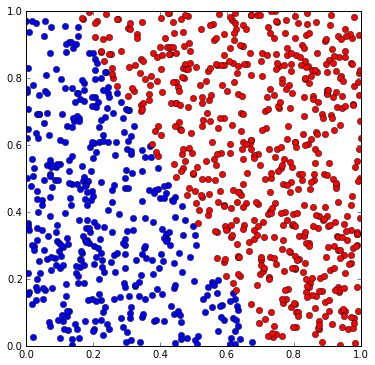

In [158]:
# linear classification problem
def plotdata(data,labels):
    d0 = data[labels==0]
    d1 = data[labels==1]
    figure(figsize=(6,6)); xlim((0,1)); ylim((0,1))
    plot(d0[:,0],d0[:,1],"bo")
    plot(d1[:,0],d1[:,1],"ro")
    
data,labels = make_linear(1000)
plotdata(data,labels)

# Single Layer Training

In order to use our logistic regression layer, we need to invoke `forward`, `backward`, and `update` in the right order.

This is handled by the `Network` class.

Let's start with a simple version for one layer.

In [189]:
class Network1:
    def __init__(self,ninput,nclasses):
        self.ninput = ninput
        self.nclasses = nclasses
        self.layer = Layer(ninput,nclasses)
        self.eta = 0.1
    def train(self,x,c):
        # compute target vector
        target = zeros(self.nclasses)
        target[c] = 1
        # perform forward computation
        pred = self.layer.forward(x)
        # compute delta
        delta = pred-target
        # perform backward propagation
        self.layer.backward(delta)
        # update the weights
        self.layer.update(self.eta)
    def pred(self,x):
        pred = self.layer.forward(x)
        return argmax(pred)

Let's create and train a network.



In [160]:
network = Network1(2,2)

for i in range(50000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

Use the network for prediction and compute the error rate.



In [161]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[1 0 1 0 1 1 1 0 0 0]
[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]


0.010999999999999999

In [162]:
print network.layer

<__main__.Layer instance at 0x3863c20>


# Multilayer Training

For multilayer training, we need a slightly more complicated network object, performing three steps during training and prediction.

- forward step: propagate the input vector through all the layers
- delta computation
- backward step: propagate the delta vector backwards through all the layers
- weight update for all the layers

In [163]:
class Network:
    def __init__(self,layers):
        self.layers = layers
        self.eta = 0.1
    def train(self,x,c):
        target = zeros(self.layers[-1].noutput)
        target[c] = 1
        temp = x
        # forward propagation
        for l in self.layers:
            temp = l.forward(temp)
        # output delta
        delta = temp-target
        # backward propagation
        for l in self.layers[::-1]:
            delta = l.backward(delta)
        # weight update
        for l in self.layers:
            l.update(self.eta)
    def pred(self,x):
        temp = x
        for l in self.layers:
            temp = l.forward(temp)
        return argmax(temp)

## Single Layer Learning

The new `Network` class should work for single layer training as well, so let's give that a try.



In [164]:
network = Network([Layer(2,2)])

for i in range(50000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

And the error rate is...



In [165]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[1 0 1 0 1 1 1 0 0 0]
[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]


0.010999999999999999

## Multilayer Learning

Now the real purpose of the `Network` class: multilayer training.



In [166]:
network = Network([Layer(2,4),Layer(4,2)])

for i in range(50000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

And the error rate...



In [168]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[1 0 1 0 1 1 1 0 0 0]
[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]


0.001

## Nonlinear Problem with Multilayer

The multilayer network should be able to solve nonlinear classification problems.



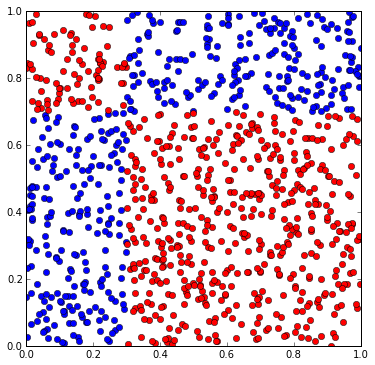

In [169]:
def make_nonlinear(n):data,labels = make_linear(1000)

    data = random_sample((n,2))
    labels = ((data[:,0]-0.3) * (0.7-data[:,1]) > 0.0)
    return data,labels
data,labels = make_nonlinear(1000)
plotdata(data,labels)

Training (with 10 hidden units).



In [170]:
network = Network([Layer(2,10),Layer(10,2)])
network.eta = 1.0

for i in range(100000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

Prediction.



In [171]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[0 0 1 0 1 0 0 0 1 0]
[0, 0, 1, 1, 1, 0, 0, 0, 1, 0]


0.025000000000000001

# Defining a New Layer Type

Training is now completely encapsulated in the `forward`, `backward` and `update` methods.
We can therefore easily define different layer types.



In [190]:
# new layer type with a different output transformation
class LinearLayer(Layer):
    def forward(self,x):
        # forward propagate x through the network
        self.x[:] = x
        y = dot(self.A,x)+self.a # UPDATED FUNCTION
        self.y[:] = y
        return y
    def backward(self,delta):
        # compute the pre-nonlinearity delta
        delta_y = delta # UPDATED DERIV
        # compute the weight updates
        self.DA += outer(delta_y,self.x)
        self.da += delta_y
        # propagate the delta backwards
        delta_x = dot(delta_y,self.A)
        return delta_x

Let's try single layer training.



In [191]:
data,labels = make_linear(1000)

network = Network([LinearLayer(2,2)])
network.eta = 0.01

for i in range(50000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

In [192]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[1 1 0 1 0 0 0 1 1 0]
[1, 1, 0, 1, 0, 0, 0, 1, 1, 0]


0.021000000000000001

And now let's try the new layer type in multilayer training.



In [193]:
network = Network([LinearLayer(2,4),Layer(4,2)])
network.eta = 0.01

for i in range(50000):
    index = randint(0,len(data))
    network.train(data[index],labels[index])

In [194]:
pred = [network.pred(x) for x in data]
print 1*labels[:10]
print pred[:10]
sum(labels!=pred) * 1.0/len(labels)

[1 1 0 1 0 0 0 1 1 0]
[1, 1, 0, 1, 0, 0, 0, 1, 1, 0]


0.014

Note that inserting a `LinearLayer` into an MLP doesn't actually do anything in this case; it can still only solve the same problem as a single logistic regression layer (why?).

But a linear layer can be useful for dimensionality reduction, in a network like this:



In [195]:
network = Network([LinearLayer(1000,4),Layer(4,4),Layer(4,2)])

# Networks with Branches

(layers and bundles)

The above examples are still just layers stacked on top of one another.
There is a lot you can do with such network architectures.

The most general case, however, is networks with branches. In such networks, you need a bit more abstraction than what is shown above. A good architecture is the following:

- `Area` - holds activations and deltas
- `Bundle` - connects two layers, holds weights, propagates activations and deltas
- `Network` - collects bundles and layers and updates them in the right order

What we used to call a `Layer` is now a combination of an `Area` and a `Bundle`.

(branches)

For a split (i.e., a `Area` used as an input to multiple `Bundle` instances), the bundles just propagate their deltas back and add them up in the layer.

For a merge (i.e., multiple outputs turning into a single `Layer`), in simple cases, the outputs can also just add up.

In the more general case, you can define a `Bundle` with multiple inputs and non-linear internal functions (e.g., multiplication).

(update order)

Layers and bundles for a directed graph.

The update order is given by a topological sort of that graph.